In [1]:
import os
import metnum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize

## Pruebas

El objetivo principal de esta notebook es entender la relación que hay entre:

* el tamaño del conjunto de entrenamiento (trainset)
* k de knn, para nuestra implementación al clasificar clases
* a de pca, para nuestra implementación al clasificar clases
* K de K-fold, como validador del parámetro encontrado teniendo en cuenta las métricas propuestas

Utilizando como punto de comparación las métricas mencionadas. Para ello se hicieron una serie de corridas en las cuales se varian esas variables:

* el trainset tomando las particiones set[0, i * 2000] sobre el total de 10000 elementos del dataset (0.8 trainset)
* k de knn entre [1, 51] en intervalos de 5 unidades
* a de pca entre [10, 100] en intervalos de 10 unidades
* K de K-fold en el conjunto {5, 10, 15, 20}

## Replica

> :~/../notebooks$ ./exp -h

o bien

> :~/../notebooks$ ./parallel


Los resultados quedan en el directorio `knnpca_results/`.

Para cada una de estas corridas obtuvimos detalles que exploramos a continuación.

## Explorando los datos

Traemos los csv arrojados por las pruebas

In [2]:
data_files = os.listdir('knnpca_results')

def load_files(filenames):
    for filename in filenames:
        yield pd.read_csv(f"knnpca_results/{filename}")

data = pd.concat(load_files(data_files), ignore_index=True)

data.describe()

,accuracy,cohen_kappa,duration,f1,kfold,knn,pca,precision,recall,train_size
count,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000
mean,0.907540,0.896865,0.504169,0.907658,15.000000,26.000000,55.000000,0.914664,0.907540,5000.000000
std,0.034512,0.038545,0.501076,0.034284,5.000114,15.811748,28.723466,0.029112,0.034512,2236.118799
min,0.750000,0.721728,0.032694,0.744496,5.000000,1.000000,10.000000,0.753910,0.750000,2000.000000
25%,0.887500,0.874666,0.166260,0.887160,10.000000,11.000000,30.000000,0.896816,0.887500,3500.000000
50%,0.915000,0.904930,0.365158,0.914546,15.000000,26.000000,55.000000,0.919768,0.915000,5000.000000
75%,0.932584,0.924928,0.652454,0.932873,20.000000,41.000000,80.000000,0.936223,0.932584,6500.000000
max,0.980000,0.977606,6.241511,0.981165,20.000000,51.000000,100.000000,0.985714,0.980000,8000.000000


## Análisis

¿Cuál es la mejor combinación? Buscando por media de métrica más alta por ejemplo:

In [208]:
grouped = data.groupby(['train_size', 'knn', 'pca', 'kfold']).mean()

idx = []
metrics = grouped.columns.values

metrics = np.delete(metrics, np.argwhere(metrics == 'duration'))

for metric in metrics:
    print(f"Media más alta para {metric}")
    idx = grouped[[metric]].idxmax()[metric]
    print(grouped.loc[idx])
    print("==================")

Media más alta para accuracy
accuracy       0.953375
cohen_kappa    0.948059
duration       0.828337
f1             0.953332
precision      0.954457
recall         0.953375
Name: (8000, 1, 40, 20), dtype: float64
Media más alta para cohen_kappa
accuracy       0.953375
cohen_kappa    0.948059
duration       0.828337
f1             0.953332
precision      0.954457
recall         0.953375
Name: (8000, 1, 40, 20), dtype: float64
Media más alta para f1
accuracy       0.953375
cohen_kappa    0.948059
duration       0.828337
f1             0.953332
precision      0.954457
recall         0.953375
Name: (8000, 1, 40, 20), dtype: float64
Media más alta para precision
accuracy       0.953375
cohen_kappa    0.948059
duration       0.828337
f1             0.953332
precision      0.954457
recall         0.953375
Name: (8000, 1, 40, 20), dtype: float64
Media más alta para recall
accuracy       0.953375
cohen_kappa    0.948059
duration       0.828337
f1             0.953332
precision      0.954457
rec

Observemos que justamente la mejor combinación se dá en el trainset que coincide con la prueba hecha sobre los 10000 elementos del dataset con un 80% utilizados para entrenar, que son 8000 elementos. Utilizar __1-nn__ con __a= 40__ verificado utilizando cross validation __20-fold__ nos otorga la mayor media en cada métrica obtenida, en particular en el accuracy. Esto dispara la pregunta __¿Por que 20-fold nos dá la mayor certeza al elegir (k, a) y no otro?__: para obtener una intuición sobre esto, podemos graficar el accuracy por ejemplo, en función de los valores que tomó K-fold para distintos tamaños del trainset utilizando 1-nn con a = 40 obtenido.


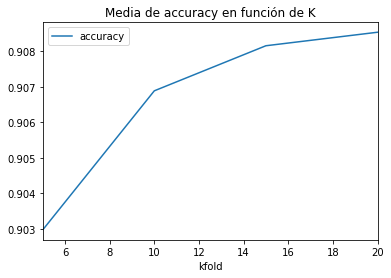

In [205]:
grouped = data.groupby(['kfold']).mean()[['accuracy']]
grouped.plot(title='Media de accuracy en función de K')

Nos dice que los accuracy más altos obtenidos se corresponden (fueron verificados) con los K (K-fold) más altos.

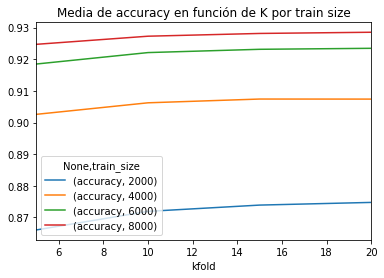

In [206]:
grouped = data.groupby(['kfold', 'train_size']).mean()[['accuracy']]
grouped.unstack(level=1).plot(title="Media de accuracy en función de K por train size")

Se puede observar que el accuracy mejora no solo dependiendo del valor de K (k-fold), si no también del tamaño del trainset que se utilizó. Esto es consistente con la elección hecha previamente: sobre la partición de 10000 elementos (el más grande) y un K (k-fold) de 20.

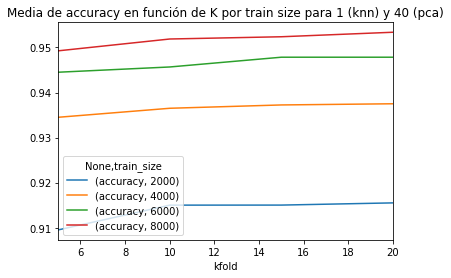

In [209]:
knn=1
pca=40

grouped = data.groupby(['knn', 'pca', 'kfold', 'train_size']).mean()[['accuracy']]
grouped.loc[knn, pca].unstack(level=1).plot(title=f"Media de accuracy en función de K por train size para {knn} (knn) y {pca} (pca)")

Lo mencionado, se corrobora con la elección de parámetros hechos.

### Sobre el tiempo demandado

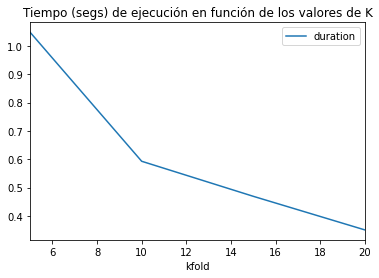

In [103]:
grouped = data.groupby(['kfold']).mean()
grouped[['duration']].plot(title='Tiempo (segs) de ejecución en función de los valores de K')